In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd drive/My\ Drive/CPD/Regression\ Tasks

/content/drive/My Drive/CPD/Regression Tasks


In [0]:
from sklearn.datasets import fetch_california_housing
import pandas as pd 
import numpy as np
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from CP_Model import CP_Based
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout 
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow import keras 
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import time


In [0]:
def local_feature_mapping(x_train,x_val,x_test,local_dim=2,unit_norm=False):
    
    n_train_samples = x_train.shape[0]
    n_val_samples = x_val.shape[0]
    n_test_samples = x_test.shape[0]
    n_features = x_train.shape[1]

    X_transformed_train_list = []
    X_transformed_val_list = []
    X_transformed_test_list = []
    
    for d in range(local_dim-1):
        X_transformed_train_list.append(x_train**(d+1))
        X_transformed_val_list.append(x_val**(d+1))
        X_transformed_test_list.append(x_test**(d+1))
         
    X_stand_train_list = [np.ones((n_train_samples,n_features))]
    X_stand_val_list = [np.ones((n_val_samples,n_features))]
    X_stand_test_list = [np.ones((n_test_samples,n_features))]
    
    for X_trans_train,X_trans_val,X_trans_test in zip(X_transformed_train_list,X_transformed_val_list,X_transformed_test_list):
        
        # scaler=StandardScaler()
        # X_stand_train_list.append(scaler.fit_transform(X_trans_train))
        # X_stand_val_list.append(scaler.transform(X_trans_val))    
        # X_stand_test_list.append(scaler.transform(X_trans_test))  
      X_stand_train_list.append(X_trans_train)
      X_stand_val_list.append(X_trans_val) 
      X_stand_test_list.append(X_trans_test)
        
    x_train_processed= np.transpose(X_stand_train_list,(1, 2, 0))
    x_val_processed= np.transpose(X_stand_val_list,(1, 2, 0))
    x_test_processed = np.transpose(X_stand_test_list,(1, 2, 0))

    if(unit_norm==True):
      norms_train = np.sqrt(np.sum(x_train_processed**2,axis=-1,keepdims=True))
      x_train_processed = np.divide(x_train_processed,norms_train)

      norms_val = np.sqrt(np.sum(x_val_processed**2,axis=-1,keepdims=True))
      x_val_processed = np.divide(x_val_processed,norms_val)
    
      norms_test = np.sqrt(np.sum(x_test_processed**2,axis=-1,keepdims=True))
      x_test_processed = np.divide(x_test_processed,norms_test)

    return x_train_processed, x_val_processed, x_test_processed      




In [0]:
class OrderReg(keras.regularizers.Regularizer):
    def __init__(self,coef,beta,local_dim):
        self.coef=coef
        self.beta=beta
        self.local_dim=local_dim
    def __call__(self,kernel):
        exp_weights = tf.constant([self.beta**i for i in range(self.local_dim)], shape=(self.local_dim, 1, 1, 1))
        kernel_weighted = kernel*exp_weights
        kernel_weighted = tf.transpose(kernel_weighted, perm=[2,3,0,1]) # N x units x d x m
        penalty = tf.matmul(tf.transpose(kernel_weighted, perm=[0,1,3,2]),kernel_weighted)
        return self.coef*tf.reduce_sum(penalty)
    def get_config(self):
        return{"coef":self.coef,"beta":self.beta,"local_dim":self.local_dim}


#Artificial Regression

In [0]:
np.random.seed(42)

N_samples = 3000
N_features = 7
std_noise = 100.0

X = np.random.uniform(0,10,(N_samples,N_features))
#y = -5+3*X[:,0]-2*X[:,1]-2*X[:,2]+4*X[:,3]+2*X[:,0]*X[:,1]+1.0*X[:,1]*X[:,2]-0.8*X[:,2]*X[:,3]+0.5*X[:,0]*X[:,1]*X[:,3]+np.random.normal(0.0,std_noise,N_samples)

y = 1000+6*X[:,0]-4*X[:,2]-3*X[:,0]*X[:,1]+4*X[:,2]*X[:,3]+3*X[:,0]*X[:,1]+0.5*(X[:,0]**2)*X[:,1]+0.2*(X[:,1]**2)*X[:,2]+0.1*(X[:,1]**2)*X[:,2]*X[:,3]+np.random.normal(0.0,std_noise,N_samples)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train, X_val, X_test= scaler_X.fit_transform(X_train), scaler_X.transform(X_val), scaler_X.transform(X_test)
y_train, y_val = scaler_y.fit_transform(y_train.reshape(-1,1)).ravel(), scaler_y.transform(y_val.reshape(-1,1)).ravel()




In [0]:
##### Linear Regression #####
start = time.time()
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)
y_pred = lin_reg.predict(X_val)
val_mse = mean_squared_error(y_pred, y_val)
#cv_score = cross_val_score(lin_reg,X_train,y_train,scoring='neg_mean_squared_error',cv=5)
end = time.time()
print(end-start)
#print('Linear Regression MSE:{}'.format(-cv_score.mean()))
print('Linear Regression MSE:{}'.format(val_mse))

0.004152059555053711
Linear Regression MSE:0.33115400605449596


In [0]:
#### SVM RBF Kernel ####
start = time.time()
svr_rbf = SVR(kernel='rbf',C=10.0)
svr_rbf.fit(X_train,y_train)
y_pred = svr_rbf.predict(X_val)
val_mse = mean_squared_error(y_pred, y_val)
#cv_score = cross_val_score(svr_rbf,X_train,y_train,scoring='neg_mean_squared_error',cv=5)
end = time.time()
print(end-start)
#print('SVR RBF MSE:{}'.format(-cv_score.mean()))
print('SVR RBF MSE:{}'.format(val_mse))

1.2285923957824707
SVR RBF MSE:0.1790704982678583


In [0]:
#### Neural Network ####
model_nn=Sequential()
model_nn.add(Dense(20,activation='relu'))
model_nn.add(BatchNormalization())
model_nn.add(Dense(20,activation='relu'))
model_nn.add(BatchNormalization())
model_nn.add(Dense(15,activation='relu'))
model_nn.add(BatchNormalization())
model_nn.add(Dense(1,activation=None))
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model_nn.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())
start = time.time()
history_nn=model_nn.fit(X_train, y_train, epochs=100, batch_size=32,validation_data=(X_val,y_val))
end = time.time()
print(end-start)
print('NN MSE:{}'.format(min(history_nn.history['val_loss'])))

Train on 1920 samples, validate on 480 samples
Epoch 1/100
1920/1920 [==============================] - 2s 916us/sample - loss: 1.0884 - val_loss: 0.7653
Epoch 2/100
1920/1920 [==============================] - 0s 89us/sample - loss: 0.6057 - val_loss: 0.5549
Epoch 3/100
1920/1920 [==============================] - 0s 90us/sample - loss: 0.4578 - val_loss: 0.3982
Epoch 4/100
1920/1920 [==============================] - 0s 87us/sample - loss: 0.3811 - val_loss: 0.2949
Epoch 5/100
1920/1920 [==============================] - 0s 92us/sample - loss: 0.3306 - val_loss: 0.2628
Epoch 6/100
1920/1920 [==============================] - 0s 101us/sample - loss: 0.2915 - val_loss: 0.2583
Epoch 7/100
1920/1920 [==============================] - 0s 98us/sample - loss: 0.2969 - val_loss: 0.2415
Epoch 8/100
1920/1920 [==============================] - 0s 97us/sample - loss: 0.2756 - val_loss: 0.2288
Epoch 9/100
1920/1920 [==============================] - 0s 97us/sample - loss: 0.2644 - val_loss: 0.22

In [0]:
cp_rank=10
local_dim=3
x_train_processed,x_val_processed,x_test_processed=local_feature_mapping(X_train,X_val,X_test,local_dim=local_dim)
print('rank: {}, local dimension:{}'.format(cp_rank,local_dim))

model=Sequential()
model.add(CP_Based(units=1,activation=None,cp_rank=cp_rank,local_dim=local_dim,
                    initializer=keras.initializers.TruncatedNormal(mean=0, stddev=0.2)))
    # regularizer=OrderReg(coef=1e-3,beta=1.0,local_dim=local_dim),
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())

start = time.time()
history=model.fit(x_train_processed, y_train, epochs=100, batch_size=32,validation_data=(x_val_processed,y_val))
end = time.time()

train_loss=min(history.history['loss'])
val_loss=min(history.history['val_loss'])
print('Training Time:{}'.format(end-start))
print('train loss:{}'.format(train_loss))
print('validation loss:{}'.format(val_loss))

rank: 10, local dimension:3
    def call(self, X):
            
#        feat_tensor = tf.transpose([1-X,X],perm=[1, 2, 0]) # for images 
#        feat_tensor = tf.transpose([tf.sqrt(1-X**2),X],perm=[1, 2, 0]) # fpr regression
#        X_square=X**2

#        X_square=(X_square-tf.reduce_mean(X_square,axis=0,keepdims=True))/tf.math.reduce_std(X_square,axis=0,keepdims=True)
#        feat_tensor = tf.transpose([tf.ones(tf.shape(X)),X,X_square],perm=[1, 2, 0]) # fpr regression
#        feat_tensor = tf.transpose([tf.ones(tf.shape(X)),X],perm=[1, 2, 0]) # fpr regression
        feat_tensor=X
        
        output_list=[]
        
        for unit in range(0,self.units):                 
                    
            feat_tensor_reshaped=tf.transpose(feat_tensor,perm=[1,0,2]) # NxNtxd
            weights=tf.transpose(self.kernel[:,:,:,unit],perm=[2,0,1]) # Nxdxm
            test=tf.matmul(feat_tensor_reshaped,weights) # NxNtxm
            test_hadamard=tf.reduce_prod(test,axis=0) # Ntx

#California Housing 

In [0]:
### Data preprocessing ###
dataset = fetch_california_housing()
X_full, Y_full = dataset.data, dataset.target
x_train, x_test, y_train, y_test = train_test_split(X_full, Y_full, test_size = 0.2, random_state = 0)
x_train, x_val, y_train, y_val = x_train[:13208],x_train[13208:], y_train[:13208],y_train[13208:]

scaler_X = StandardScaler()
scaler_Y = StandardScaler()

x_train, x_val, x_test= scaler_X.fit_transform(x_train), scaler_X.transform(x_val), scaler_X.transform(x_test)
y_train, y_val, y_test = scaler_Y.fit_transform(y_train.reshape(-1,1)).ravel(), scaler_Y.transform(y_val.reshape(-1,1)).ravel(), scaler_Y.transform(y_test.reshape(-1,1)).ravel()


In [0]:
##### Linear Regression #####
start = time.time()
lin_reg = LinearRegression()
lin_reg.fit(x_train,y_train)
y_pred = lin_reg.predict(x_val)
val_mse = mean_squared_error(y_pred, y_val)
#cv_score = cross_val_score(lin_reg,X_train,y_train,scoring='neg_mean_squared_error',cv=5)
end = time.time()
print(end-start)
#print('Linear Regression MSE:{}'.format(-cv_score.mean()))
print('Linear Regression MSE:{}'.format(val_mse))

0.023911476135253906
Linear Regression MSE:0.3712142442969637


In [0]:
#### SVR Polynomial Kernel ####
start = time.time()
svr_poly = SVR(kernel='poly',degree=3,C=1.0,epsilon=1)
svr_poly.fit(x_train,y_train)
y_pred = svr_poly.predict(x_val)
y_pred_train = svr_poly.predict(x_train)
train_mse = mean_squared_error(y_pred_train, y_train)
val_mse = mean_squared_error(y_pred, y_val)
#cv_score = cross_val_score(svr_poly,X_train,y_train,scoring='neg_mean_squared_error',cv=5)
end = time.time()
print(end-start)
#print('SVR Poly MSE:{}'.format(-cv_score.mean()))
print('SVR Train Poly MSE:{}'.format(train_mse))
print('SVR Poly MSE:{}'.format(val_mse))


41.855961322784424
SVR Train Poly MSE:0.5222889568347701
SVR Poly MSE:0.5979396648103871


In [0]:
#### SVR RBF Kernel ####
start = time.time()
svr_rbf = SVR(kernel='rbf',C=10.0)
svr_rbf.fit(x_train,y_train)
y_pred = svr_rbf.predict(x_val)
val_mse = mean_squared_error(y_pred, y_val)
#cv_score = cross_val_score(svr_rbf,X_train,y_train,scoring='neg_mean_squared_error',cv=5)
end = time.time()
print(end-start)
#print('SVR RBF MSE:{}'.format(-cv_score.mean()))
print('SVR RBF MSE:{}'.format(val_mse))

18.78395414352417
SVR RBF MSE:0.22361283511419183


In [0]:
#### Neural Network ####
model=Sequential()
model.add(Dense(40,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(30,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(30,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(30,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(10))
model.add(BatchNormalization())
model.add(Dense(1))

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())

start = time.time()
history=model.fit(x_train, y_train, epochs=100, batch_size=32,validation_data=(x_val,y_val))
end = time.time()
print(end-start)
print('NN MSE:{}'.format(min(history.history['val_loss'])))
model.summary()

Train on 13208 samples, validate on 3304 samples
Epoch 1/100
13208/13208 [==============================] - 3s 242us/sample - loss: 0.5086 - val_loss: 0.3450
Epoch 2/100
13208/13208 [==============================] - 2s 115us/sample - loss: 0.3571 - val_loss: 0.3050
Epoch 3/100
13208/13208 [==============================] - 1s 110us/sample - loss: 0.3251 - val_loss: 0.2691
Epoch 4/100
13208/13208 [==============================] - 1s 110us/sample - loss: 0.3088 - val_loss: 0.2677
Epoch 5/100
13208/13208 [==============================] - 1s 110us/sample - loss: 0.2959 - val_loss: 0.2447
Epoch 6/100
13208/13208 [==============================] - 1s 112us/sample - loss: 0.2884 - val_loss: 0.2616
Epoch 7/100
13208/13208 [==============================] - 2s 115us/sample - loss: 0.2818 - val_loss: 0.2530
Epoch 8/100
13208/13208 [==============================] - 1s 111us/sample - loss: 0.2755 - val_loss: 0.2673
Epoch 9/100
13208/13208 [==============================] - 1s 113us/sample - lo

rank: 20, local dimension:75
    def call(self, X):
            
#        feat_tensor = tf.transpose([1-X,X],perm=[1, 2, 0]) # for images 
#        feat_tensor = tf.transpose([tf.sqrt(1-X**2),X],perm=[1, 2, 0]) # fpr regression
#        X_square=X**2

#        X_square=(X_square-tf.reduce_mean(X_square,axis=0,keepdims=True))/tf.math.reduce_std(X_square,axis=0,keepdims=True)
#        feat_tensor = tf.transpose([tf.ones(tf.shape(X)),X,X_square],perm=[1, 2, 0]) # fpr regression
#        feat_tensor = tf.transpose([tf.ones(tf.shape(X)),X],perm=[1, 2, 0]) # fpr regression
        feat_tensor=X
        
        output_list=[]
        
        for unit in range(0,self.units):                 
                    
            feat_tensor_reshaped=tf.transpose(feat_tensor,perm=[1,0,2]) # NxNtxd
            weights=tf.transpose(self.kernel[:,:,:,unit],perm=[2,0,1]) # Nxdxm
            test=tf.matmul(feat_tensor_reshaped,weights) # NxNtxm
            test_hadamard=tf.reduce_prod(test,axis=0) # Nt

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in square


    def call(self, X):
            
#        feat_tensor = tf.transpose([1-X,X],perm=[1, 2, 0]) # for images 
#        feat_tensor = tf.transpose([tf.sqrt(1-X**2),X],perm=[1, 2, 0]) # fpr regression
#        X_square=X**2

#        X_square=(X_square-tf.reduce_mean(X_square,axis=0,keepdims=True))/tf.math.reduce_std(X_square,axis=0,keepdims=True)
#        feat_tensor = tf.transpose([tf.ones(tf.shape(X)),X,X_square],perm=[1, 2, 0]) # fpr regression
#        feat_tensor = tf.transpose([tf.ones(tf.shape(X)),X],perm=[1, 2, 0]) # fpr regression
        feat_tensor=X
        
        output_list=[]
        
        for unit in range(0,self.units):                 
                    
            feat_tensor_reshaped=tf.transpose(feat_tensor,perm=[1,0,2]) # NxNtxd
            weights=tf.transpose(self.kernel[:,:,:,unit],perm=[2,0,1]) # Nxdxm
            test=tf.matmul(feat_tensor_reshaped,weights) # NxNtxm
            test_hadamard=tf.reduce_prod(test,axis=0) # Ntxm   
            output=tf.r

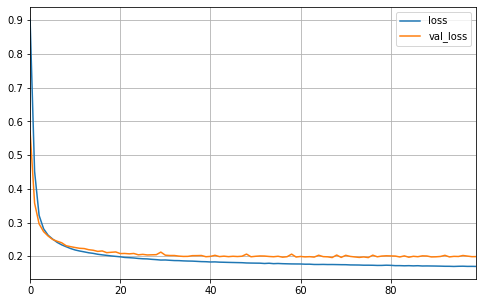

4128/4128 [==============================] - 0s 44us/sample - loss: 0.1980
Test MSE:0.19802677287727363
Training time:118.84296131134033


In [0]:
cp_rank=20
local_dim=75

x_train_processed,x_val_processed,x_test_processed=local_feature_mapping(x_train,x_val,x_test,local_dim=local_dim,unit_norm=True)

print('rank: {}, local dimension:{}'.format(cp_rank,local_dim))

model=Sequential()
model.add(CP_Based(units=1,activation=None,cp_rank=cp_rank,local_dim=local_dim,regularizer=keras.regularizers.l2(3e-7),

                    initializer=keras.initializers.TruncatedNormal(mean=0, stddev=0.2)))
# ,regularizer=keras.regularizers.l2(2e-7),
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())

start = time.time()
history=model.fit(x_train_processed, y_train, epochs=100, batch_size=32,validation_data=(x_val_processed,y_val))
end = time.time()

train_loss=min(history.history['loss'])
val_loss=min(history.history['val_loss'])
print('train loss:{}'.format(train_loss))
print('validation loss:{}'.format(val_loss))

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()
   
print('Test MSE:{}'.format(model.evaluate(x_test_processed,y_test)))
print('Training time:{}'.format(end-start))



In [0]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
all_order_7 (AllOrder)       multiple                  4000      
Total params: 4,000
Trainable params: 4,000
Non-trainable params: 0
_________________________________________________________________
